In [1]:
import pandas as pd
import numpy as np
import time
import multiprocessing
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from statannot import add_stat_annotation

## Density Plot

In [16]:
# region distribution

df = pd.read_csv('~/DRAP/data/c_elegans/transcript/mRNA_WS275_WITHregion_v3.csv')
df = df.rename(columns={'Gene name':'ref_id','sequence_length':'length'})

del df['Type']
del df['Gene ID']
del df['sequence']

df['ALL'] = '1-' + (df['length']).astype(str)
df['UTR5'] = '1-' + (df['CDS start']-1).astype(str)
df['CDS'] = (df['CDS start']).astype(str) + '-' + (df['CDS end']).astype(str)
df['UTR3'] = (df['CDS end']+1).astype(str) + '-' + (df['length']).astype(str)

for i in range(len(df)):
    if df.at[i,'CDS start'] == 1:
        df.at[i,'UTR5'] = np.NaN
    if df.at[i,'CDS end'] == df.at[i,'length']:
        df.at[i,'UTR3'] = np.NaN

del df['CDS start']
del df['CDS end']
del df['length']

df.to_csv('~/DRAP/analyze/metadata/mRNA_WS275_3region.csv', index=False)

In [627]:
def region_analyze(read_df, ref_df, column, set_region=True, set_count=True, set_length=False, set_density=False):
    
    # inner function to find length of overlap-region
    # x is a dataframe with four columns: 
    # [init_pos_x, end_pos_x, init_pos_y, end_pos_y] 
    def _overlap(x):
        sorted_x = sorted(x)
        return sorted_x[2] - sorted_x[1] + 1
    
    # split positions from column of ref_df
    position = ref_df[column].str.split('-', expand=True)
    df_ref = pd.DataFrame()
    if set_region:
        df_ref[column] = ref_df[column].copy()
    df_ref['init_pos'] = position[0].fillna(-1).astype(int)
    df_ref['end_pos'] = position[1].fillna(-1).astype(int)
    
    # copy columns from read_df
    df = read_df[['ref_id','read_count','init_pos','end_pos']]
    
    # merge two dataframe
    # read_df: init_pos_x, end_pos_x
    # ref_df: init_pos_y, end_pos_y
    df = pd.merge(df, df_ref, on='ref_id')
    df['len'] = df['end_pos_x'] - df['init_pos_x'] + 1
    df['len_overlap'] = 0
    
    # find reads that overlap with region
    df_tmp = df.loc[
        (df['init_pos_x']<=df['end_pos_y']) & (df['init_pos_y']<=df['end_pos_x']),
        ['init_pos_x','end_pos_x','init_pos_y','end_pos_y']
    ]
    len_overlap = df_tmp.apply(lambda x: _overlap(x), axis=1)
    df.loc[len_overlap.index, 'len_overlap'] = len_overlap
    
    # calculate the ratio of read-count
    df[column+'_count'] = df['read_count'] * df['len_overlap'] / df['len']
    
    # merge read-count to ref_df
    df = df.groupby('ref_id')[column+'_count'].sum()
    df_ref = pd.merge(df_ref, df, on='ref_id', how='left')
    
    # add columns of 'region', read-count', 'length', 'density'
    df_ref[column+'_count'].fillna(0, inplace=True)
    if set_length:
        df_ref.loc[ df_ref['init_pos']>0, column+'_len'] = df_ref['end_pos'] - df_ref['init_pos'] + 1
    if set_density:
        df_ref.loc[ df_ref['init_pos']>0, column+'_den'] = df_ref[column+'_count'] / (df_ref['end_pos'] - df_ref['init_pos'] + 1)
    if set_count:
        df_ref.loc[ df_ref['init_pos']<0, column+'_count'] = np.nan
    else:
        df_ref.drop(columns=[column+'_count'], inplace=True)
    
    del df_ref['init_pos']
    del df_ref['end_pos']

    return df_ref

In [628]:
def multi_region_analyze(read_df, ref_df, columns, set_region=True, set_count=True, set_length=False, set_density=False):
    
    # built argument list
    arg_lst  = []
    for col in columns:
        arg_lst.append((read_df,ref_df,col,set_region,set_count,set_length,set_density))
    
    # multiprocessing
    pool = multiprocessing.Pool()
    res = pool.starmap(region_analyze, arg_lst)
    pool.close()
    pool.join()
    df = pd.concat(res, axis=1)
    
    return df

In [9]:
df_ref = pd.read_csv('~/DRAP/analyze/metadata/mRNA_WS275_3region.csv', index_col='ref_id')
df = pd.read_csv('~/DRAP/preprocess/metadata/HRDE1_WT_rep1.csv', comment='#')

12


In [67]:
# iterator

T = time.time()

res_lst = []
columns = ['UTR5','CDS','UTR3']
for col in columns:
    df_tmp = region_analyze(
        read_df = df,
        ref_df = df_ref,
        column = col,
    )
    res_lst.append(df_tmp)


df_test = pd.concat(res_lst, axis=1)

print(time.time()-T)

33.034345388412476


In [66]:
# multiprocessing: apply async

T = time.time()

cores = multiprocessing.cpu_count()
pool = multiprocessing.Pool(processes=cores-2)

res_lst = []
columns = ['UTR5','CDS','UTR3']
for col in columns:
    res = pool.apply_async(region_analyze, (df,df_ref,col,))
    res_lst.append(res.get())

pool.close()
pool.join()

df_test = pd.concat(res_lst, axis=1)

print(time.time()-T)

36.6270649433136


In [65]:
# multiprocessing: starmap

T = time.time()

df_test = multi_region_analyze(
    read_df = df,
    ref_df = df_ref,
    columns = ['UTR5','CDS','UTR3'],
    set_region = True,
    set_count = True,
    set_length = False,
    set_density = True
)

print(time.time()-T)

28.970662832260132


In [890]:
df = pd.read_csv('~/DRAP/analyze/metadata/data4_all_mRNA_tool1.csv', comment='#')
df['CDS_den'] = df['countcds']/df['lencds']
df['UTR5_den'] = df['count5']/df['len5']
df['UTR3_den'] = df['count3']/df['len3']
df = df.rename(columns={'Gene name':'ref_id'})
columns = ['UTR5_den','CDS_den','UTR3_den']
#df = df[['ref_id']+columns]
df

,Gene ID,sequence_length,ref_id,CDS start,CDS end,len5,lencds,len3,count5,countcds,count3,CDS_den,UTR5_den,UTR3_den
0,gene=WBGene00007063,2004,2L52.1a.1,20,1303,19,1284,701,0.000000,9867.531765,1892.403352,7.684994,0.000000,2.699577
1,gene=WBGene00007063,2138,2L52.1a.2,20,1303,19,1284,835,0.000000,9867.531765,2703.433360,7.684994,0.000000,3.237645
2,gene=WBGene00007063,1364,2L52.1b.1,1,663,0,663,701,0.000000,9462.016761,1892.403352,14.271518,NaN,2.699577
3,gene=WBGene00007064,2329,2RSSE.1a.1,270,1301,269,1032,1028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,gene=WBGene00007064,2291,2RSSE.1b.1,270,1706,269,1437,585,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,gene=WBGene00007064,2028,2RSSE.1c.1,270,1046,269,777,982,0.000000,0.000000,964.310799,0.000000,0.000000,0.981987
6,gene=WBGene00007065,823,3R5.1a.1,14,661,13,648,162,0.000000,8921.330089,811.030008,13.767485,0.000000,5.006358
7,gene=WBGene00007065,806,3R5.1b.1,9,644,8,636,162,0.000000,8110.300081,811.030008,12.752044,0.000000,5.006358
8,gene=WBGene00003525,1457,4R79.1a.1,283,1317,282,1035,140,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,gene=WBGene00003525,543,4R79.1b.1,1,543,0,543,0,0.000000,0.000000,0.000000,0.000000,NaN,NaN


In [891]:
df = df.melt(id_vars=['ref_id'], value_vars=columns, var_name='region')
df = df.dropna().reset_index(drop=True)
df2 = df.copy()
df['data'] = 'data4.1'
df2['data'] = 'data4.2'
df = pd.concat([df,df2]).reset_index(drop=True)
df

,ref_id,region,value,data
0,2L52.1a.1,UTR5_den,0.000000,data4.1
1,2L52.1a.2,UTR5_den,0.000000,data4.1
2,2RSSE.1a.1,UTR5_den,0.000000,data4.1
3,2RSSE.1b.1,UTR5_den,0.000000,data4.1
4,2RSSE.1c.1,UTR5_den,0.000000,data4.1
5,3R5.1a.1,UTR5_den,0.000000,data4.1
6,3R5.1b.1,UTR5_den,0.000000,data4.1
7,4R79.1a.1,UTR5_den,0.000000,data4.1
8,AC3.10.1,UTR5_den,0.000000,data4.1
9,AC3.10.2,UTR5_den,0.000000,data4.1


In [873]:
with open('../../filter/WAGO-1_target', 'r') as f:
    WAGO = f.read().splitlines()
with open('../../filter/CSR-1_target', 'r') as f:
    CSR = f.read().splitlines()

In [901]:
plot_df = df.copy()
plot_df['value'] = plot_df['value'].apply(lambda x: np.log10(x*pow(10,6)) if not pd.isna(x) and x!=0 else x)
tmp1 = plot_df[plot_df['ref_id'].isin(WAGO)]
tmp1.loc[:,'filter'] = 'WAGO'
tmp2 = plot_df[plot_df['ref_id'].isin(CSR)]
tmp2.loc[:,'filter'] = 'CSR'
plot_df = pd.concat([tmp1,tmp2]).reset_index(drop=True)
plot_df

,ref_id,region,value,data,filter
0,2L52.1a.1,UTR5_den,0.000000,data4.1,WAGO
1,2L52.1a.2,UTR5_den,0.000000,data4.1,WAGO
2,B0035.5.1,UTR5_den,0.000000,data4.1,WAGO
3,B0047.1.1,UTR5_den,8.577009,data4.1,WAGO
4,B0198.1.1,UTR5_den,7.675759,data4.1,WAGO
5,B0205.5.1,UTR5_den,8.512514,data4.1,WAGO
6,B0207.12a.3,UTR5_den,0.000000,data4.1,WAGO
7,B0207.12a.4,UTR5_den,0.000000,data4.1,WAGO
8,B0213.11a.1,UTR5_den,0.000000,data4.1,WAGO
9,B0213.11b.1,UTR5_den,6.554796,data4.1,WAGO


In [917]:
plot_df = plot_df[ plot_df['region']=='CDS_den']
plot_df

,ref_id,region,value,data,filter
2803,2L52.1a.1,CDS_den,6.885644,data4.1,WAGO
2804,2L52.1a.2,CDS_den,6.885644,data4.1,WAGO
2805,2L52.1b.1,CDS_den,7.154470,data4.1,WAGO
2806,AC8.10.1,CDS_den,8.820096,data4.1,WAGO
2807,AC8.11.1,CDS_den,8.399884,data4.1,WAGO
2808,AC8.3.1,CDS_den,8.822615,data4.1,WAGO
2809,AC8.4.1,CDS_den,8.399884,data4.1,WAGO
2810,B0035.5.1,CDS_den,7.830685,data4.1,WAGO
2811,B0047.1.1,CDS_den,9.538367,data4.1,WAGO
2812,B0198.1.1,CDS_den,7.244395,data4.1,WAGO


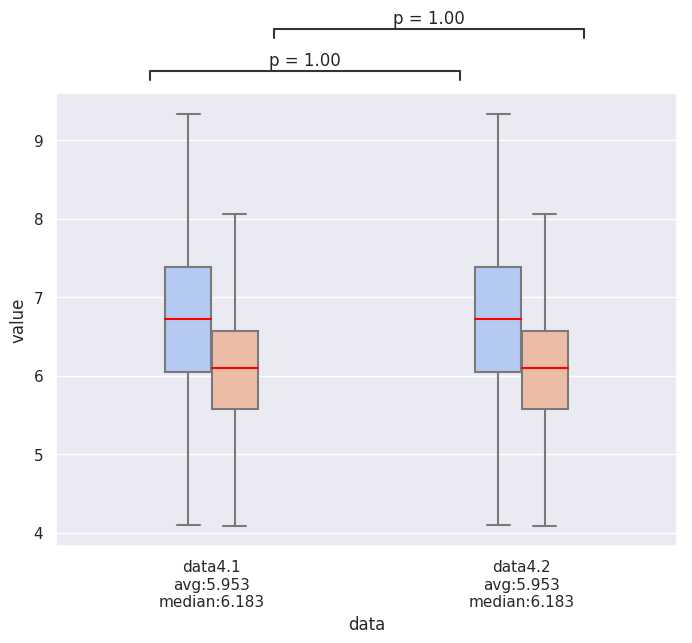

In [978]:
sns.set(style="darkgrid")
fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_subplot(1,1,1)
ax = sns.boxplot(data=plot_df, x='data', y='value', hue='filter', showfliers=False, width=0.3, showmeans=False, medianprops=dict(color='red'), palette='coolwarm')
#ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax.get_legend().remove()
list2 = ['WAGO','CSR']
#columns = ['UTR5_den','CDS_den','UTR3_den']
list1=['data4.1','data4.2']
#pairs = list(itertools.combinations(columns, 2))
pairs = [tuple((x, y) for x in list1) for y in list2]

add_stat_annotation(ax, data=plot_df, x='data', y='value', hue='filter', box_pairs=pairs,
                    test='Mann-Whitney', text_format='simple', loc='outside', verbose=0)


#fig.suptitle("Iris Data", y=-0.01)


columns=['data4.1','data4.2']
mean_list = [round(plot_df.loc[plot_df['data']==column,'value'].mean(),3) for column in columns]
median_list = [round(plot_df.loc[plot_df['data']==column,'value'].median(),3) for column in columns]
new_columns = ["{}\navg:{}\nmedian:{}".format(column, mean, median) for (column,mean,median) in zip(columns,mean_list,median_list)]
rename_dict = dict(zip(columns, new_columns))
labels = ax.get_xticklabels()
ax.set_xticklabels([rename_dict[col.get_text()] for col in labels])


plt.show()

## Metagene Plot

In [131]:
# metagene distribution

bin_size = 100

df = pd.read_csv('~/DRAP/data/c_elegans/transcript/mRNA_WS275_WITHregion_v3.csv')
df = df.rename(columns={'Gene name':'ref_id','sequence_length':'length'})
df = df[['ref_id','length']]
df['bin_len'] = df['length']/bin_size

for i in trange(len(df)):
    for num in range(bin_size):
        init_pos = int(df.at[i,'bin_len']*num) + 1
        end_pos = int(df.at[i,'bin_len']*(num+1))
        df.at[i,'b'+str(num+1)] = str(init_pos)+'-'+str(end_pos)

del df['length']
del df['bin_len']

df.to_csv('~/DRAP/analyze/metadata/mRNA_WS275_metagene.csv', index=False)

100%|██████████| 43040/43040 [03:43<00:00, 192.39it/s]


In [654]:
df.to_csv('~/DRAP/analyze/metadata/mRNA_WS275_metagene.csv', index=False)
df

,ref_id,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,2L52.1a.1,1-20,21-40,41-60,61-80,81-100,101-120,121-140,141-160,161-180,...,1804-1823,1824-1843,1844-1863,1864-1883,1884-1903,1904-1923,1924-1943,1944-1963,1964-1983,1984-2004
1,2L52.1a.2,1-21,22-42,43-64,65-85,86-106,107-128,129-149,150-171,172-192,...,1925-1945,1946-1966,1967-1988,1989-2009,2010-2031,2032-2052,2053-2073,2074-2095,2096-2116,2117-2138
2,2L52.1b.1,1-13,14-27,28-40,41-54,55-68,69-81,82-95,96-109,110-122,...,1228-1241,1242-1254,1255-1268,1269-1282,1283-1295,1296-1309,1310-1323,1324-1336,1337-1350,1351-1364
3,2RSSE.1a.1,1-23,24-46,47-69,70-93,94-116,117-139,140-163,164-186,187-209,...,2097-2119,2120-2142,2143-2165,2166-2189,2190-2212,2213-2235,2236-2259,2260-2282,2283-2305,2306-2329
4,2RSSE.1b.1,1-22,23-45,46-68,69-91,92-114,115-137,138-160,161-183,184-206,...,2062-2084,2085-2107,2108-2130,2131-2153,2154-2176,2177-2199,2200-2222,2223-2245,2246-2268,2269-2291
5,2RSSE.1c.1,1-20,21-40,41-60,61-81,82-101,102-121,122-141,142-162,163-182,...,1826-1845,1846-1865,1866-1886,1887-1906,1907-1926,1927-1946,1947-1967,1968-1987,1988-2007,2008-2028
6,3R5.1a.1,1-8,9-16,17-24,25-32,33-41,42-49,50-57,58-65,66-74,...,741-748,749-757,758-765,766-773,774-781,782-790,791-798,799-806,807-814,815-823
7,3R5.1b.1,1-8,9-16,17-24,25-32,33-40,41-48,49-56,57-64,65-72,...,726-733,734-741,742-749,750-757,758-765,766-773,774-781,782-789,790-797,798-806
8,4R79.1a.1,1-14,15-29,30-43,44-58,59-72,73-87,88-101,102-116,117-131,...,1312-1325,1326-1340,1341-1355,1356-1369,1370-1384,1385-1398,1399-1413,1414-1427,1428-1442,1443-1457
9,4R79.1b.1,1-5,6-10,11-16,17-21,22-27,28-32,33-38,39-43,44-48,...,489-494,495-499,500-504,505-510,511-515,516-521,522-526,527-532,533-537,538-543


In [629]:
# multiprocessing: starmap

df_ref = pd.read_csv('~/DRAP/analyze/metadata/mRNA_WS275_metagene.csv', index_col='ref_id')
df = pd.read_csv('~/DRAP/preprocess/metadata/HRDE1_WT_rep1.csv', comment='#')

T = time.time()
print("start!")

df_test = multi_region_analyze(
    read_df = df,
    ref_df = df_ref,
    columns = ['b'+str(i) for i in range(1,101)],
    set_region = False,
    set_count = True,
    set_length = False,
    set_density = False
)

print(time.time()-T)

start!
61.189327001571655


In [630]:
df_test = df_test.round(3)
columns = df_test.columns.to_list()
new_columns = [col.split('_')[0] for col in columns]
df_test = df_test.rename(columns=dict(zip(columns,new_columns)))
df_test

,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,...,b91,b92,b93,b94,b95,b96,b97,b98,b99,b100
ref_id,,,,,,,,,,,,,,,,,,,,,
2L52.1a.1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,1.484,1.484,0.000,0.000
2L52.1a.2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2L52.1b.1,0.000,0.000,2.265,3.538,0.464,1.716,0.924,4.096,11.366,5.697,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2RSSE.1a.1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2RSSE.1b.1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2RSSE.1c.1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3R5.1a.1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.270,0.000,0.000,0.000,0.194,0.581,0.516,0.194,0.000,0.000
3R5.1b.1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.472,0.000,0.000,0.000,0.000,0.452,0.516,0.516,0.000,0.000
4R79.1a.1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [1191]:
df = pd.read_csv("/home/ryan/DRAP/analyze/metadata/data4_metagene.csv", comment='#')
columns = df.columns.tolist()
columns.remove('ref_id')
df

,ref_id,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,2L52.1a.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,36.865000,49.153334,221.190002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,2L52.1a.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,110.595001,159.748335,0.000000,221.190002,49.153334,0.000000,0.000000,0.000000,0.000000,0.0
2,2L52.1b.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,283.700220,642.733267,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,2RSSE.1a.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,2RSSE.1b.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,2RSSE.1c.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
6,3R5.1a.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,52.893261,158.679784,141.048697,52.893261,0.000000,0.0
7,3R5.1b.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,70.524349,141.048697,141.048697,52.893261,0.000000,0.0
8,4R79.1a.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
9,4R79.1b.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [1018]:
df = df.melt(id_vars=['ref_id'], value_vars=columns, var_name='region')
#df = df[df['value']!=0].reset_index(drop=True)
df['region'] = df['region'].astype(int)
#df2 = df.copy()
#df['data'] = 'data4.1'
#df2['data'] = 'data4.2'
#df = pd.concat([df,df2]).reset_index(drop=True)
df

,ref_id,region,value
0,2L52.1a.1,1,0.000000
1,2L52.1a.2,1,0.000000
2,2L52.1b.1,1,0.000000
3,2RSSE.1a.1,1,0.000000
4,2RSSE.1b.1,1,0.000000
5,2RSSE.1c.1,1,0.000000
6,3R5.1a.1,1,0.000000
7,3R5.1b.1,1,0.000000
8,4R79.1a.1,1,0.000000
9,4R79.1b.1,1,0.000000


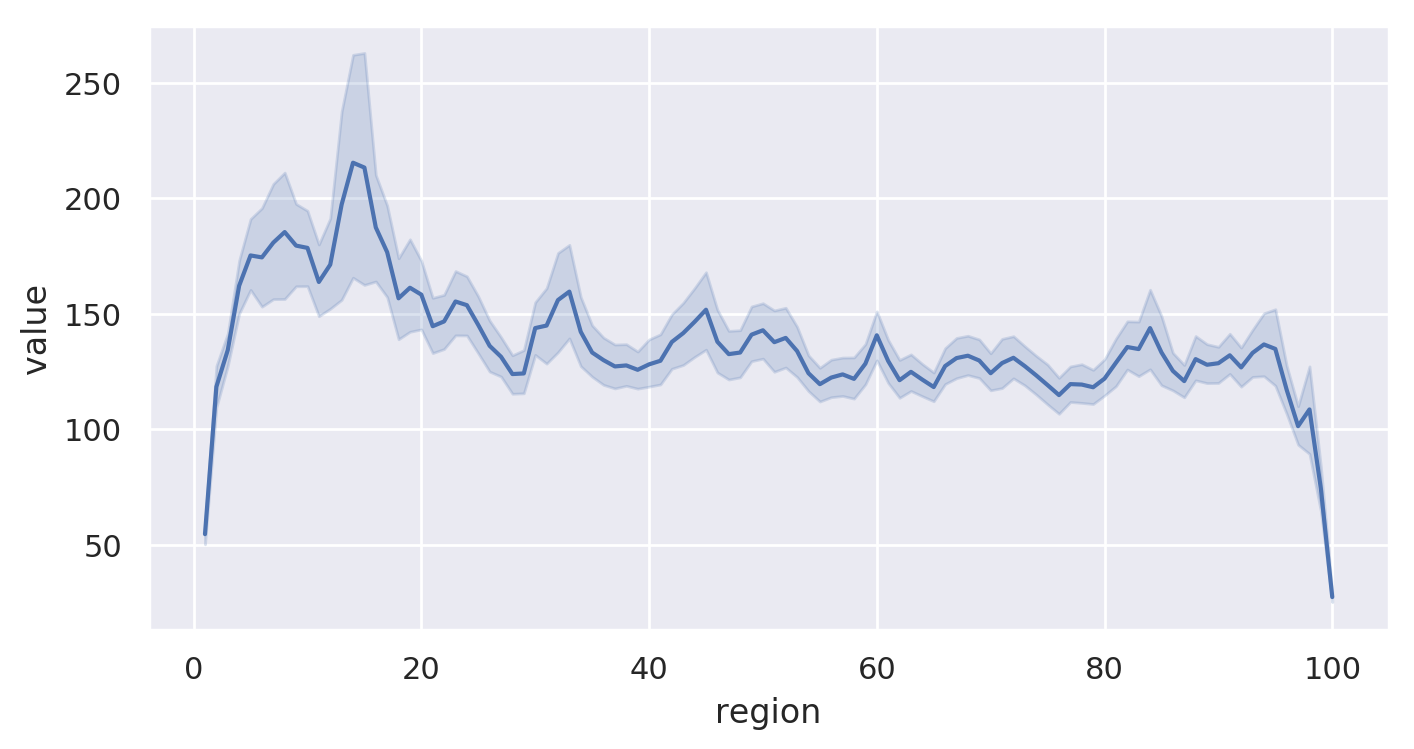

In [1019]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8,4), dpi=200)
ax = sns.lineplot(data=df, x='region', y='value', ci=68)

In [1155]:
def cal_avg(df_target):
    df = pd.DataFrame()
    df['ratio'] = df_target[df_target!=0].count() / df_target.count()
    df['avg'] = df_target.mean(axis = 0)
    df['avg_dis'] = df['avg'] / sum(df['avg'])
    df['ste'] = np.std(df_target, ddof=1) / np.sqrt(len(df_target))
    df['avg_plus_ste'] = df['avg'] + df['ste']
    df['avg_minus_ste'] = df['avg'] - df['ste']
    df['avg_plus_ste_dis'] = df['avg_plus_ste'] / sum(df['avg'])
    df['avg_minus_ste_dis'] = df['avg_minus_ste'] / sum(df['avg'])
    df = df.reset_index()
    df['index'] = df['index'].astype(int)
    return df

df_target = pd.read_csv("/home/ryan/DRAP/analyze/metadata/data4_metagene.csv", comment='#')
columns = df_target.columns.tolist()
columns.remove('ref_id')
#df_target = df_target[columns]

'''
tmp1 = df_target.loc[df_target['ref_id'].isin(WAGO), columns].reset_index(drop=True)
tmp1 = cal_avg(tmp1)
tmp1['filter'] = 'WAGO'
tmp2 = df_target.loc[df_target['ref_id'].isin(CSR), columns].reset_index(drop=True)
tmp2 = cal_avg(tmp2)
tmp2['filter'] = 'CSR'
plot_df = pd.concat([tmp1,tmp2]).reset_index(drop=True)
plot_df
'''
def _count_avg(data):
    df = pd.DataFrame()
    df['ratio'] = data[data!=0].count() / data.count()
    df['avg'] = data.mean(axis = 0)
    df['avg_dis'] = df['avg'] / sum(df['avg'])
    df['ste'] = np.std(data, ddof=1) / np.sqrt(len(data))
    df['avg_plus_ste'] = df['avg'] + df['ste']
    df['avg_minus_ste'] = df['avg'] - df['ste']
    df['avg_plus_ste_dis'] = df['avg_plus_ste'] / sum(df['avg'])
    df['avg_minus_ste_dis'] = df['avg_minus_ste'] / sum(df['avg'])
    df = df.reset_index()
    df['index'] = df['index'].astype(int)
    return df
    
def plot_data(data, filter):
    plot_df = pd.DataFrame()
    for d in data:
        tmp_df = d['dataframe']
        if filter:
            for f in filter:
                df = tmp_df.loc[tmp_df['ref_id'].isin(f['id']), columns].reset_index(drop=True)
                df = _count_avg(df)
                df['data'] = d['name']
                df['filter'] = f['name']
                plot_df = pd.concat([plot_df,df])
        else:
            df = tmp_df[columns]
            df = _count_avg(df)
            df['data'] = d['name']
            df['filter'] = 'all_mRNA'
            plot_df = pd.concat([plot_df,df])
    plot_df = plot_df.reset_index(drop=True)
    return plot_df

df_lst = [
    {'name':'data4.1',
     'dataframe':df_target
    },
    {'name':'data4.2',
     'dataframe':df_target
    },
]
filter = [
    {'name':'WAGO',
     'id': WAGO
    },
    {'name':'CSR',
     'id': CSR
    }
]
plot_df = plot_data(df_lst, filter)
plot_df

,index,ratio,avg,avg_dis,ste,avg_plus_ste,avg_minus_ste,avg_plus_ste_dis,avg_minus_ste_dis,data,filter
0,1,0.177278,248.578926,0.003119,41.514948,290.093873,207.063978,0.003640,0.002598,data4.1,WAGO
1,2,0.269210,540.661838,0.006785,60.942781,601.604619,479.719057,0.007549,0.006020,data4.1,WAGO
2,3,0.321350,669.686617,0.008404,71.191713,740.878330,598.494904,0.009297,0.007510,data4.1,WAGO
3,4,0.346323,889.135010,0.011157,118.789118,1007.924128,770.345892,0.012648,0.009667,data4.1,WAGO
4,5,0.358672,975.316409,0.012239,165.291428,1140.607837,810.024981,0.014313,0.010165,data4.1,WAGO
5,6,0.358123,959.324621,0.012038,190.966723,1150.291345,768.357898,0.014435,0.009642,data4.1,WAGO
6,7,0.356202,934.650795,0.011729,185.442431,1120.093226,749.208363,0.014056,0.009402,data4.1,WAGO
7,8,0.371295,949.082278,0.011910,201.638281,1150.720559,747.443997,0.014440,0.009379,data4.1,WAGO
8,9,0.377058,1021.455824,0.012818,177.820498,1199.276322,843.635325,0.015049,0.010587,data4.1,WAGO
9,10,0.384193,1108.439823,0.013909,180.690539,1289.130362,927.749285,0.016177,0.011642,data4.1,WAGO


In [1167]:
tmp = plot_df[plot_df['data']==f]
tmp

,index,ratio,avg,avg_dis,ste,avg_plus_ste,avg_minus_ste,avg_plus_ste_dis,avg_minus_ste_dis,data,filter
0,1,0.177278,248.578926,0.003119,41.514948,290.093873,207.063978,0.003640,0.002598,data4.1,WAGO
1,2,0.269210,540.661838,0.006785,60.942781,601.604619,479.719057,0.007549,0.006020,data4.1,WAGO
2,3,0.321350,669.686617,0.008404,71.191713,740.878330,598.494904,0.009297,0.007510,data4.1,WAGO
3,4,0.346323,889.135010,0.011157,118.789118,1007.924128,770.345892,0.012648,0.009667,data4.1,WAGO
4,5,0.358672,975.316409,0.012239,165.291428,1140.607837,810.024981,0.014313,0.010165,data4.1,WAGO
5,6,0.358123,959.324621,0.012038,190.966723,1150.291345,768.357898,0.014435,0.009642,data4.1,WAGO
6,7,0.356202,934.650795,0.011729,185.442431,1120.093226,749.208363,0.014056,0.009402,data4.1,WAGO
7,8,0.371295,949.082278,0.011910,201.638281,1150.720559,747.443997,0.014440,0.009379,data4.1,WAGO
8,9,0.377058,1021.455824,0.012818,177.820498,1199.276322,843.635325,0.015049,0.010587,data4.1,WAGO
9,10,0.384193,1108.439823,0.013909,180.690539,1289.130362,927.749285,0.016177,0.011642,data4.1,WAGO


In [1171]:
plot_df[100:200]

,index,ratio,avg,avg_dis,ste,avg_plus_ste,avg_minus_ste,avg_plus_ste_dis,avg_minus_ste_dis,data,filter
100,1,0.147336,59.524664,0.008619,5.438970,64.963634,54.085694,0.009407,0.007832,data4.1,CSR
101,2,0.239555,110.036358,0.015934,7.663994,117.700352,102.372364,0.017043,0.014824,data4.1,CSR
102,3,0.278491,122.078927,0.017677,6.092333,128.171261,115.986594,0.018560,0.016795,data4.1,CSR
103,4,0.288541,138.564652,0.020065,8.466952,147.031604,130.097700,0.021291,0.018839,data4.1,CSR
104,5,0.300297,126.279751,0.018286,7.313040,133.592791,118.966712,0.019345,0.017227,data4.1,CSR
105,6,0.300107,109.929745,0.015918,4.017826,113.947571,105.911920,0.016500,0.015336,data4.1,CSR
106,7,0.302762,109.876817,0.015911,4.192085,114.068902,105.684732,0.016518,0.015304,data4.1,CSR
107,8,0.304974,106.999765,0.015494,5.220710,112.220475,101.779055,0.016250,0.014738,data4.1,CSR
108,9,0.303710,101.246034,0.014661,4.831242,106.077276,96.414792,0.015360,0.013961,data4.1,CSR
109,10,0.294672,98.262635,0.014229,3.608396,101.871031,94.654239,0.014751,0.013706,data4.1,CSR


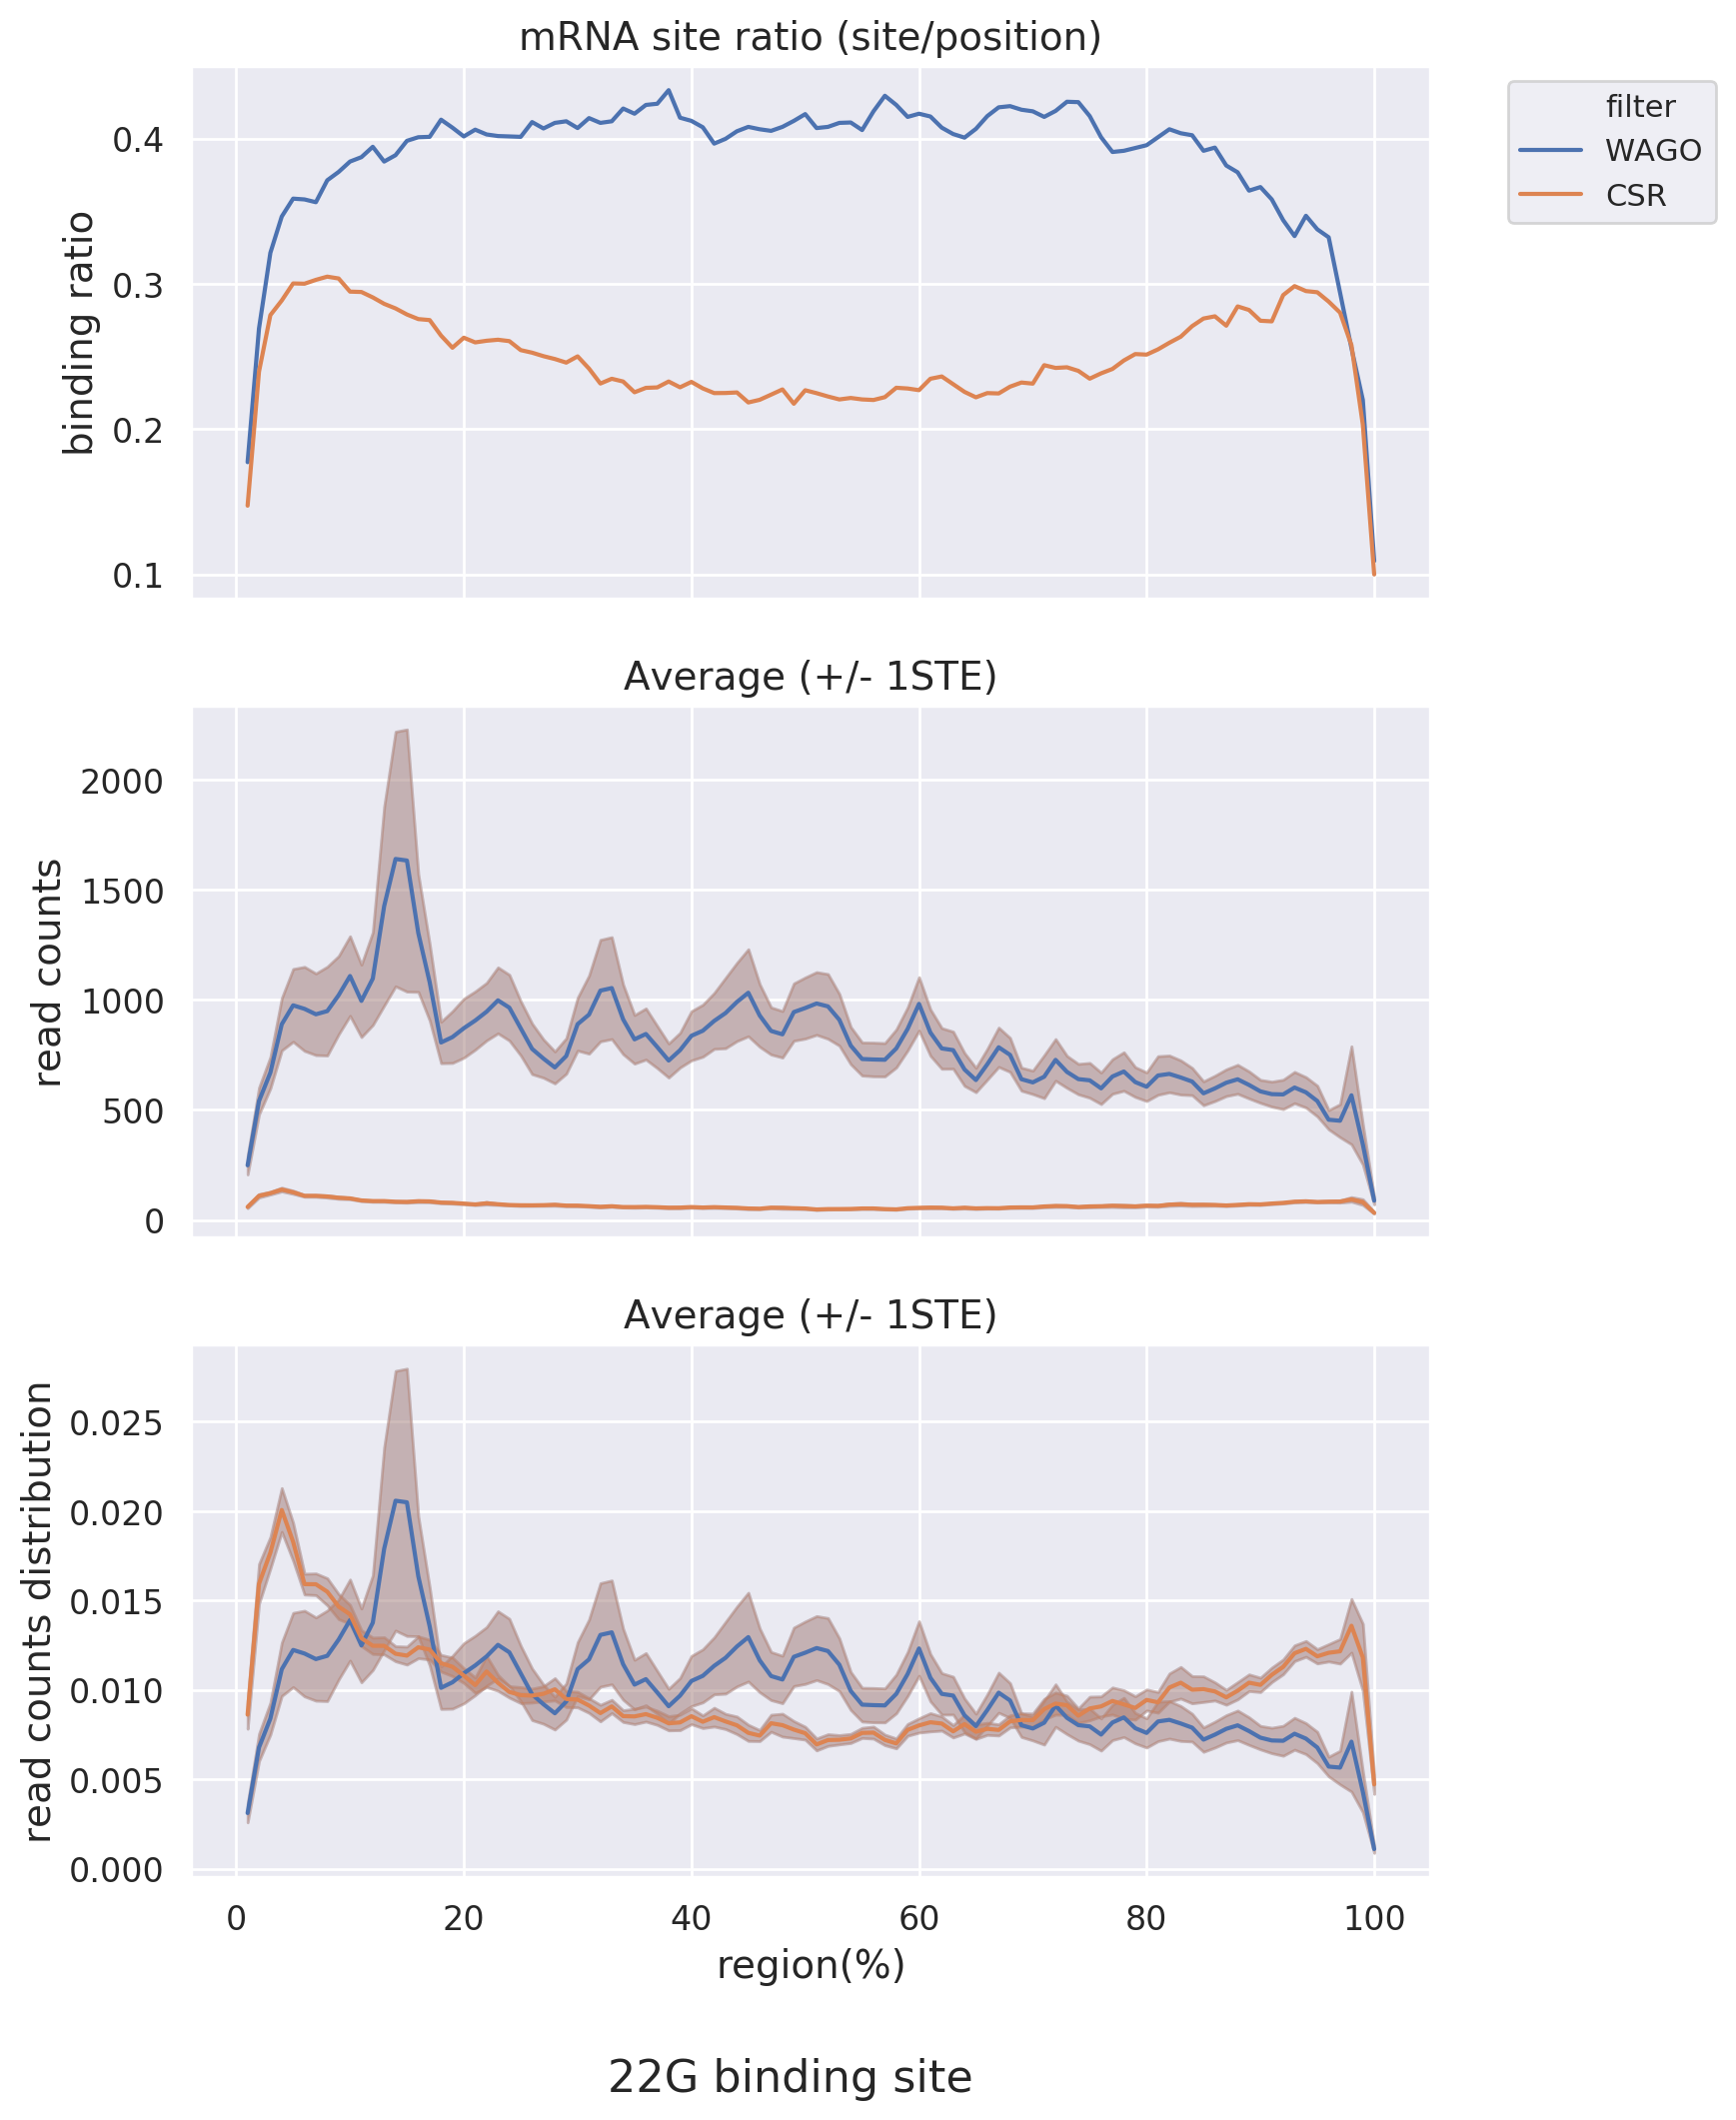

In [1185]:
filter1 = ['data4.1','data4.2']
filter2 = ['WAGO','CSR']
filter_num = len(filter1)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,12), dpi=200)

ax1 = sns.lineplot(ax=ax1, data=plot_df, x='index', y='ratio',  hue='filter', palette='deep', ci=None)
ax2 = sns.lineplot(ax=ax2, data=plot_df, x='index', y='avg',  hue='filter', palette='deep', ci=None)
ax3 = sns.lineplot(ax=ax3, data=plot_df, x='index', y='avg_dis',  hue='filter', palette='deep', ci=None)


for i1,f1 in enumerate(filter1):
    for i2,f2 in enumerate(filter2):
        tmp = plot_df[ (plot_df['data']==f1) & (plot_df['filter']==f2)]
        ax2.fill_between(tmp['index'], tmp['avg_plus_ste'], tmp['avg_minus_ste'],
                        alpha=0.3, color=sns.color_palette('deep',filter_num).as_hex()[i1])
        ax3.fill_between(tmp['index'], tmp['avg_plus_ste_dis'], tmp['avg_minus_ste_dis'],
                        alpha=0.3, color=sns.color_palette('deep',filter_num).as_hex()[i1])


'''
name = plot_df['data'].drop_duplicates().to_list()
for i in range(int(len(plot_df)/len(columns))):
    start = i*len(columns)
    end = (i+1)*len(columns)
    tmp = plot_df[start:end]
    j = name.index(tmp['data'].iloc[0])
    ax2.fill_between(tmp['index'], tmp['avg_plus_ste'], tmp['avg_minus_ste'],
                    alpha=0.3, color=sns.color_palette('deep',len(name)).as_hex()[j])
    ax3.fill_between(tmp['index'], tmp['avg_plus_ste_dis'], tmp['avg_minus_ste_dis'],
                    alpha=0.3, color=sns.color_palette('deep',len(name)).as_hex()[j])
'''
ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax1.tick_params(axis='y', labelsize=12)
ax1.set_ylabel('binding ratio', fontsize=14)
ax1.set_title("mRNA site ratio (site/position)", fontsize=14)

ax2.get_legend().remove()
ax2.tick_params(axis='y', labelsize=12)
ax2.set_ylabel('read counts', fontsize=14)
ax2.set_title("Average (+/- 1STE)", fontsize=14)

ax3.get_legend().remove()
ax3.tick_params(axis='x', labelsize=12)
ax3.tick_params(axis='y', labelsize=12)
ax3.set_xlabel('region(%)', fontsize=14)
ax3.set_ylabel('read counts distribution', fontsize=14)
ax3.set_title("Average (+/- 1STE)", fontsize=14)

fig.suptitle("22G binding site", y=0.05, fontsize=16)

plt.show()

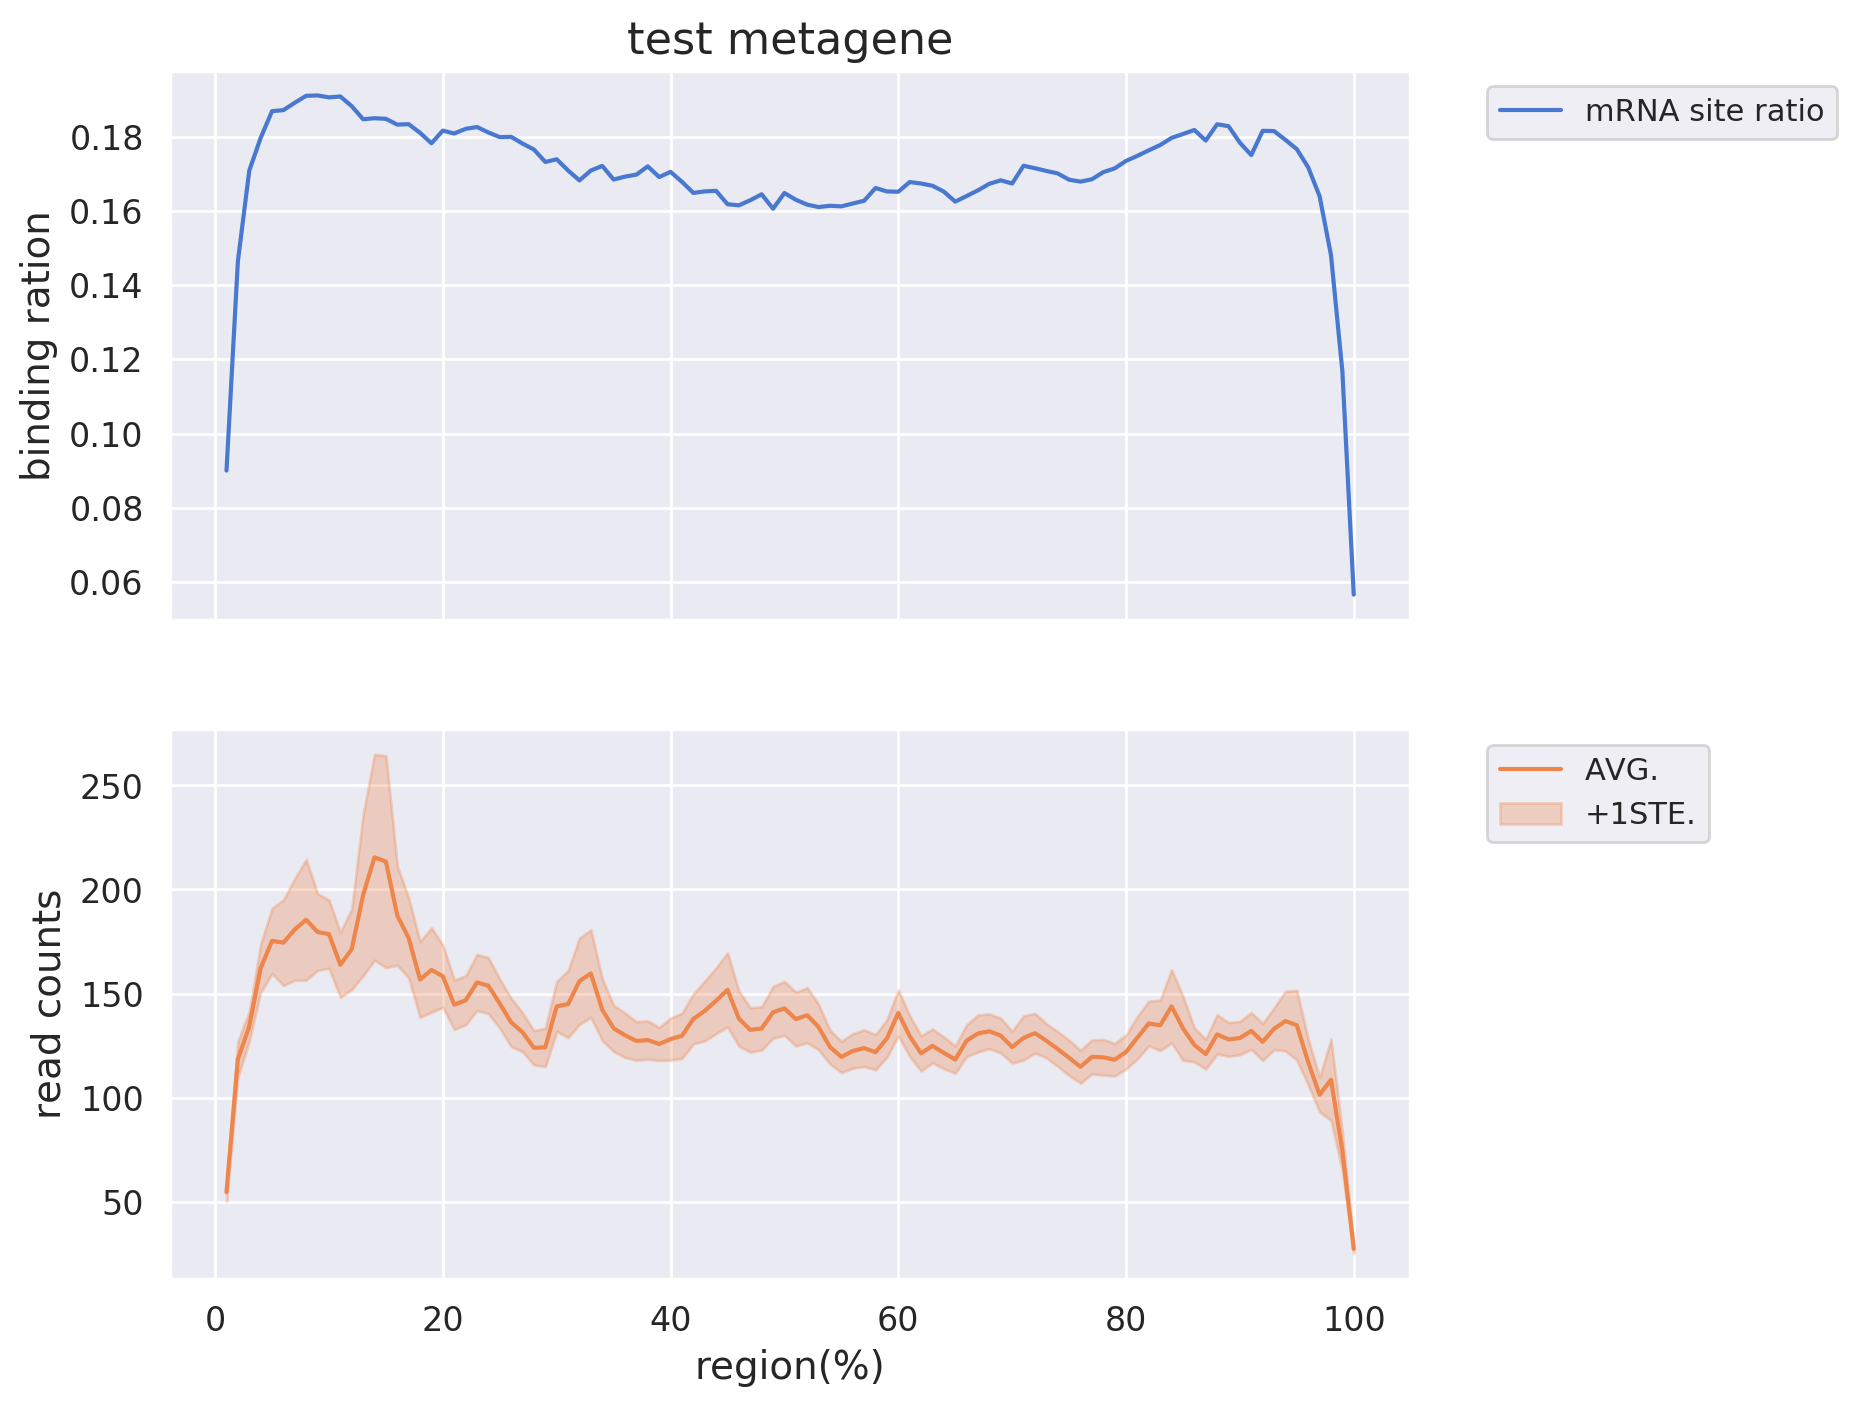

In [1074]:
# prepare data


df = pd.DataFrame()
df['ratio'] = df_target[df_target!=0].count() / df_target.count()
df['avg'] = df_target.mean(axis = 0)
df['ste'] = np.std(df_target, ddof=1) / np.sqrt(len(df_target))
df['avg_plus_ste'] = df['avg'] + df['ste']
df['avg_minus_ste'] = df['avg'] - df['ste']
df.index = df.index.astype(int)
#df.index = df.index + 1

# plot figure
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,8), dpi=200)
ax1.plot(df['ratio'], color='#4878d0')
ax1.legend(['mRNA site ratio'], bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax1.tick_params(axis='y', labelsize=12)
ax1.set_ylabel('binding ration', fontsize=14)
ax1.set_title("test metagene", fontsize=16)

ax2.plot(df['avg'], color='#ee854a')
ax2.fill_between(df.index, df['avg_plus_ste'], df['avg_minus_ste'], alpha=0.3, color='#ee854a')
ax2.legend(['AVG.', '+1STE.', '-1STE.'], bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.set_xlabel('region(%)', fontsize=14)
ax2.set_ylabel('read counts', fontsize=14)

plt.show()

## Boundary Plot

In [223]:
# boundary distribution

df = pd.read_csv('~/DRAP/data/c_elegans/transcript/mRNA_WS275_WITHregion_v3.csv')
df = df.rename(columns={'Gene name':'ref_id','CDS start':'start codon', 'CDS end':'stop codon','sequence_length':'tail'})

del df['Type']
del df['Gene ID']
del df['sequence']

df['head'] = 1
df = df[['ref_id','head','tail','start codon','stop codon']]

df.to_csv('~/DRAP/analyze/metadata/mRNA_WS275_boundary.csv', index=False)
df

,ref_id,head,tail,start codon,stop codon
0,2L52.1a.1,1,2004,20,1303
1,2L52.1a.2,1,2138,20,1303
2,2L52.1b.1,1,1364,1,663
3,2RSSE.1a.1,1,2329,270,1301
4,2RSSE.1b.1,1,2291,270,1706
5,2RSSE.1c.1,1,2028,270,1046
6,3R5.1a.1,1,823,14,661
7,3R5.1b.1,1,806,9,644
8,4R79.1a.1,1,1457,283,1317
9,4R79.1b.1,1,543,1,543


In [625]:
def analyze_single_boundary(read_df, ref_df, column, limit):
    
    # inner function to find positioins of overlap-region
    # x is a dataframe with four columns: 
    # [init_pos_x, end_pos_x, init_pos_y, end_pos_y]
    def _overlap(x):
        sorted_x = sorted(x)
        return sorted_x[1], sorted_x[2]

    # initailize
    left_limit,right_limit = limit
    df_ref = ref_df.copy()
    df_ref['index'] = df_ref.index
    try:
        df_ref['target'] = df_ref[column]
        df_ref['init_pos'] = df_ref['target'] + left_limit
        df_ref['end_pos'] = df_ref['target'] + right_limit
    except:
        print('[Error] Column "{}" is not found.'.format(column))
        sys.exit(1)
    
    # check window is in mRNA boundary (head,tail), 1-based
    check_boundary = True 
    if 'head' not in df_ref.columns:
        df_ref['head'] = 1
    if 'tail' not in df_ref.columns:
        if 'length' not in df_ref.columns:
            print('[Warning] Columns "tail" or "length" are not found, won\'t check mRNA boundary.')
            check_boundary = False
        else:
            df_ref['tail'] = df_ref['length']
    if check_boundary:
        df_ref.loc[ df_ref['init_pos']<df_ref['head'], 'init_pos'] = df_ref['head']
        df_ref.loc[ df_ref['end_pos']>df_ref['tail'], 'end_pos'] = df_ref['tail']
    
    # remain necessary columns
    df_ref = df_ref[['ref_id','index','init_pos','end_pos','head','tail','target']]
    df = read_df[['ref_id','read_count','init_pos','end_pos']]
    
    # merge two dataframe
    # read_df: init_pos_x, end_pos_x
    # ref_df: init_pos_y, end_pos_y
    df = pd.merge(df, df_ref, on='ref_id')
    
    # find reads that overlap with region
    df = df[ (df['init_pos_x']<=df['end_pos_y']) & (df['init_pos_y']<=df['end_pos_x']) ]
    
    # shift index as 0-based array
    if check_boundary:
        for col in ['head','tail']:
            df_ref[col] = df_ref[col] - df_ref['target'] - left_limit
    for col in ['init_pos_x','init_pos_y','end_pos_x','end_pos_y']:
        df[col] = df[col] - df['target'] - left_limit
    
    # find overlap positoins
    df_tmp = df[['init_pos_x','end_pos_x','init_pos_y','end_pos_y']].copy()
    overlap = df_tmp.apply(lambda x: _overlap(x), axis=1)
    df_tmp2 = pd.DataFrame(overlap.to_list(), index=df_tmp.index)
    df_tmp['init_pos'] = df_tmp2[0]   # 0-based initial position
    df_tmp['end_pos'] = df_tmp2[1]+1  # terminal of end position

    # remain necessary columns
    # [ref_id, index, read-count, init_pos, end_pos]
    df = pd.concat([df, df_tmp], axis=1).reset_index(drop=True)
    df.drop(columns=['init_pos_x','end_pos_x','init_pos_y','end_pos_y'], inplace=True)

    # build array for boundary plot
    arr = np.zeros((len(df_ref),(right_limit-left_limit+1)))
    for i in range(len(df)):
        arr[df.at[i,'index'], df.at[i,'init_pos']:df.at[i,'end_pos']] += df.at[i,'read_count']

    # build dataframe
    # set values outside the boundaries to NaN
    target_df = pd.DataFrame(arr, index=df_ref['ref_id'], 
                             columns=[*range(right_limit-left_limit+1)]).round(3)
    mask = ((target_df.columns.values < df_ref['head'].values[:, None]) |
            (target_df.columns.values > df_ref['tail'].values[:, None]))
    target_df[mask] = np.nan
    target_df.columns = [*range(left_limit,right_limit+1)]

    return target_df


def multi_boundary_analyze(read_df, ref_df, columns, limit):
    
    # built argument list
    arg_lst  = []
    for col,l in zip(columns,limit):
        arg_lst.append((read_df,ref_df,col,l))
    
    # multiprocessing
    pool = multiprocessing.Pool()
    res = pool.starmap(analyze_single_boundary, arg_lst)
    pool.close()
    pool.join()
    
    return res

In [670]:
# multiprocessing: starmap

df_ref = pd.read_csv('~/DRAP/analyze/metadata/mRNA_WS275_boundary.csv')
df = pd.read_csv('~/DRAP/preprocess/metadata/HRDE1_WT_rep1.csv', comment='#')

T = time.time()

df_lst = multi_boundary_analyze(
    read_df = df,
    ref_df = df_ref,
    columns = ['head','tail','start codon','stop codon'],
    limit = [(0,99),(-99,0),(-100,100),(-100,100)],
)

print(time.time()-T)

15.372556924819946


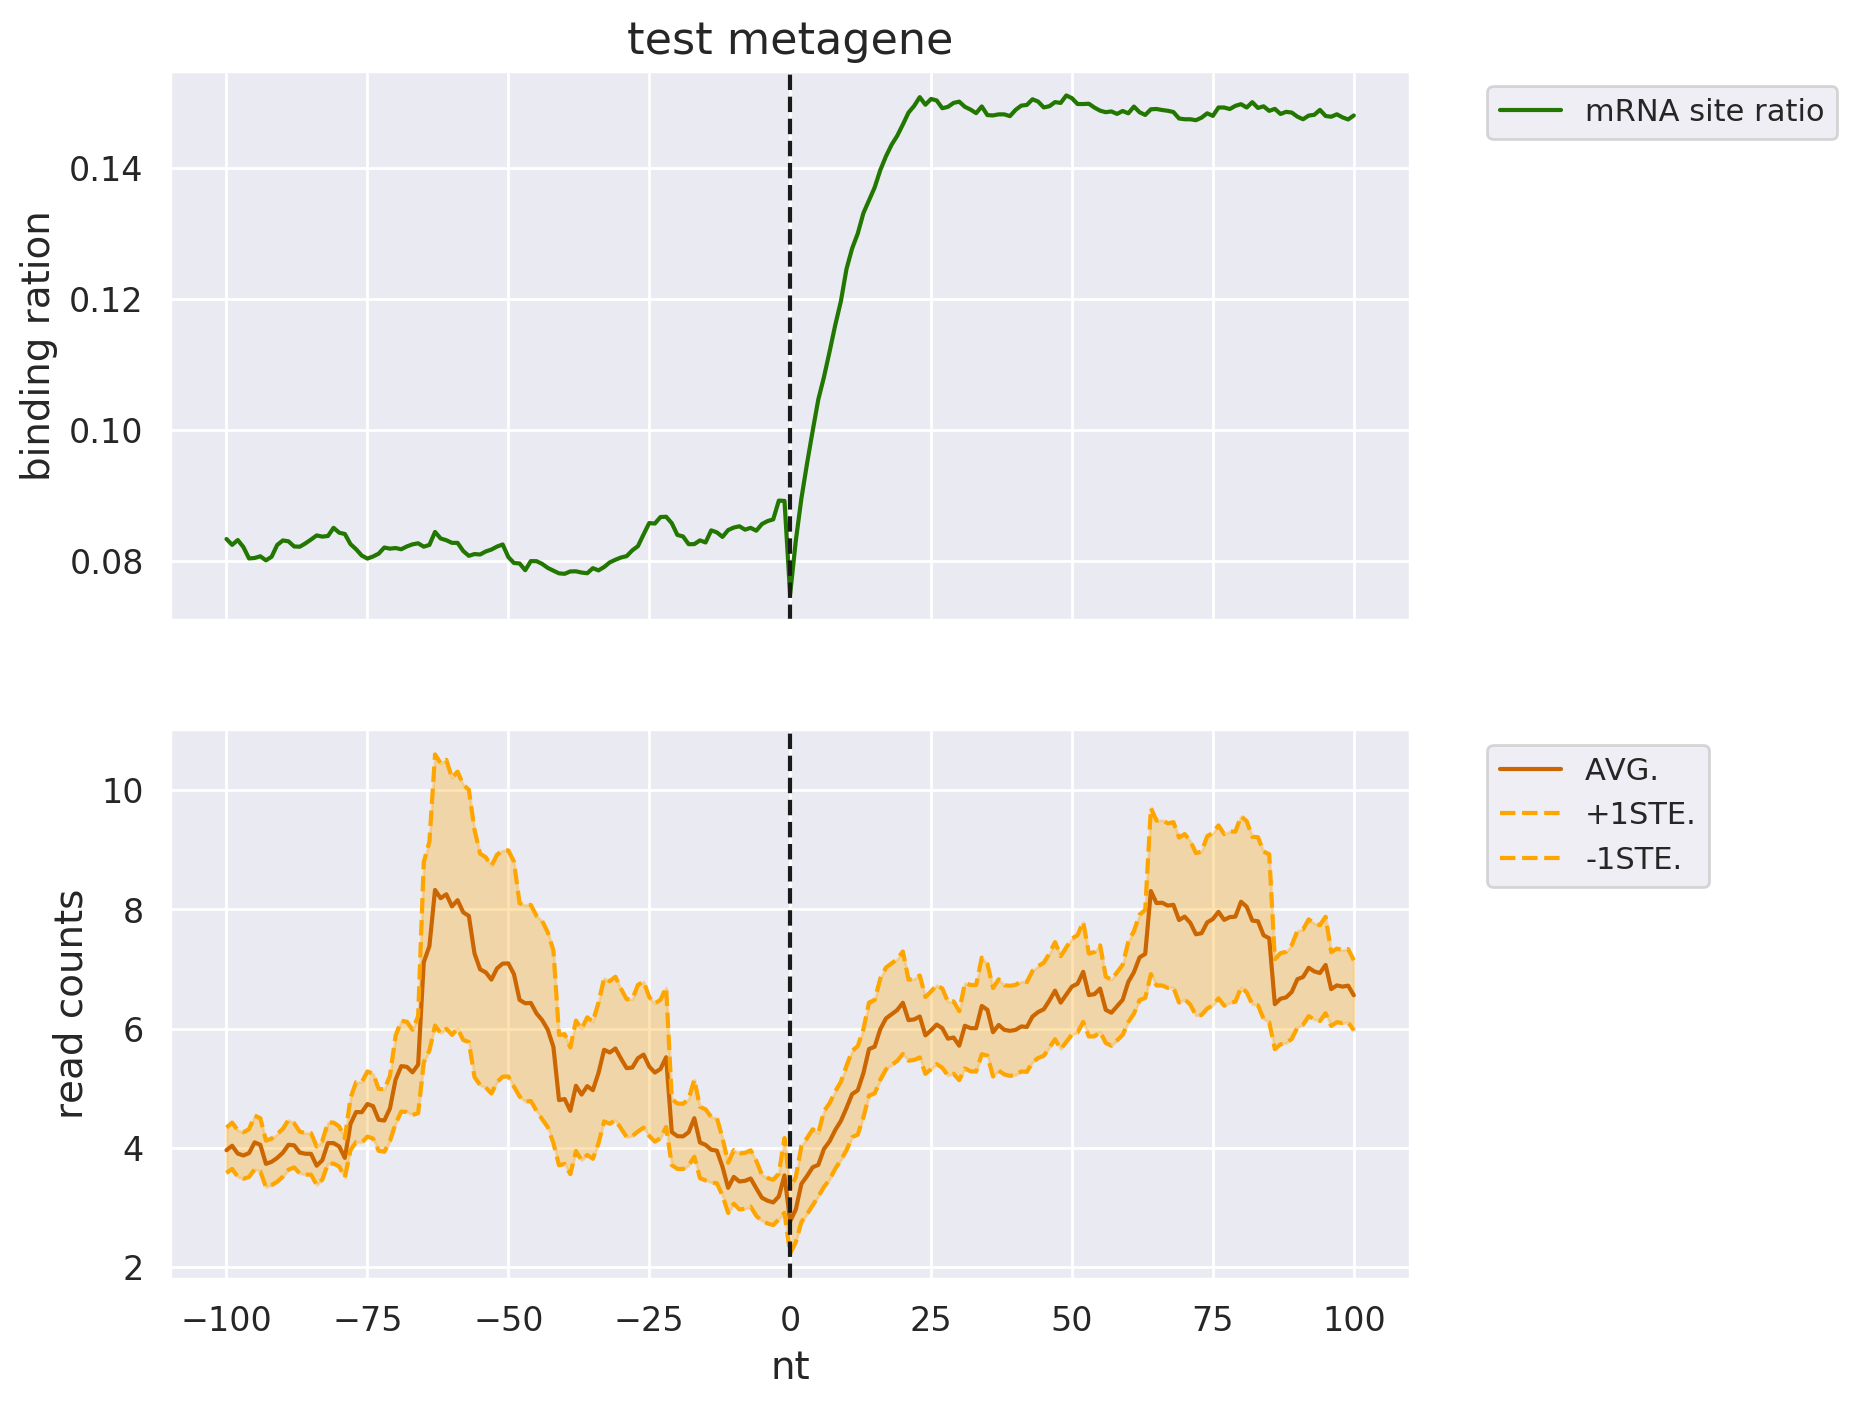

In [1059]:
# prepare data

df_target = df_lst[2]

df = pd.DataFrame()
df['avg'] = df_target.mean(axis = 0)
df['ste'] = np.std(df_target, ddof=1) / np.sqrt(len(df_target))
df['avg_plus_ste'] = df['avg'] + df['ste']
df['avg_minus_ste'] = df['avg'] - df['ste']
df['ratio'] = df_target[df_target!=0].count() / df_target.count()

# plot figure
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,8), dpi=200)
ax1.plot(df['ratio'], color='#227700')
ax1.legend(['mRNA site ratio'], bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax1.axvline(x=0,c='k',linestyle='dashed')
ax1.tick_params(axis='y', labelsize=12)
ax1.set_ylabel('binding ration', fontsize=14)
ax1.set_title("test metagene", fontsize=16)

ax2.plot(df['avg'], color='#CC6600')
ax2.plot(df['avg_plus_ste'], color='orange', linestyle='dashed')
ax2.plot( df['avg_minus_ste'], color='orange', linestyle='dashed')
ax2.fill_between(df.index, df['avg_plus_ste'], df['avg_minus_ste'], color='orange', alpha=0.3)
ax2.legend(['AVG.', '+1STE.', '-1STE.'], bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax2.axvline(x=0,c='k',linestyle='dashed')
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.set_xlabel('nt', fontsize=14)
ax2.set_ylabel('read counts', fontsize=14)

plt.show()

## Scatter Plot

In [1234]:
df = pd.read_csv('~/DRAP/analyze/metadata/data4_all_mRNA_tool1.csv', comment='#')
df['ALL_count'] = df['count5'] + df['countcds'] + df['count3']
df = df.rename(columns={'Gene name':'ref_id'})
#columns = ['UTR5_count','CDS_count','UTR3_count']
df = df[['ref_id','ALL_count']]
df = df.set_index('ref_id')
df['filter'] = 'valid'
df.loc[df['ALL_count']==0, 'filter'] = 'invalid'
alpha = np.inf
alpha = min(alpha, df['ALL_count'].replace(0.0, np.nan).min())
alpha
df['ALL_count'] = np.log2(df['ALL_count']+alpha)
df['ALL_count2'] = df['ALL_count']
df = df.reset_index()
df

,ref_id,ALL_count,filter,ALL_count2
0,2L52.1a.1,13.522884,valid,13.522884
1,2L52.1a.2,13.619016,valid,13.619016
2,2L52.1b.1,13.472304,valid,13.472304
3,2RSSE.1a.1,3.396825,invalid,3.396825
4,2RSSE.1b.1,3.396825,invalid,3.396825
5,2RSSE.1c.1,9.929027,valid,9.929027
6,3R5.1a.1,13.250134,valid,13.250134
7,3R5.1b.1,13.124745,valid,13.124745
8,4R79.1a.1,3.396825,invalid,3.396825
9,4R79.1b.1,3.396825,invalid,3.396825


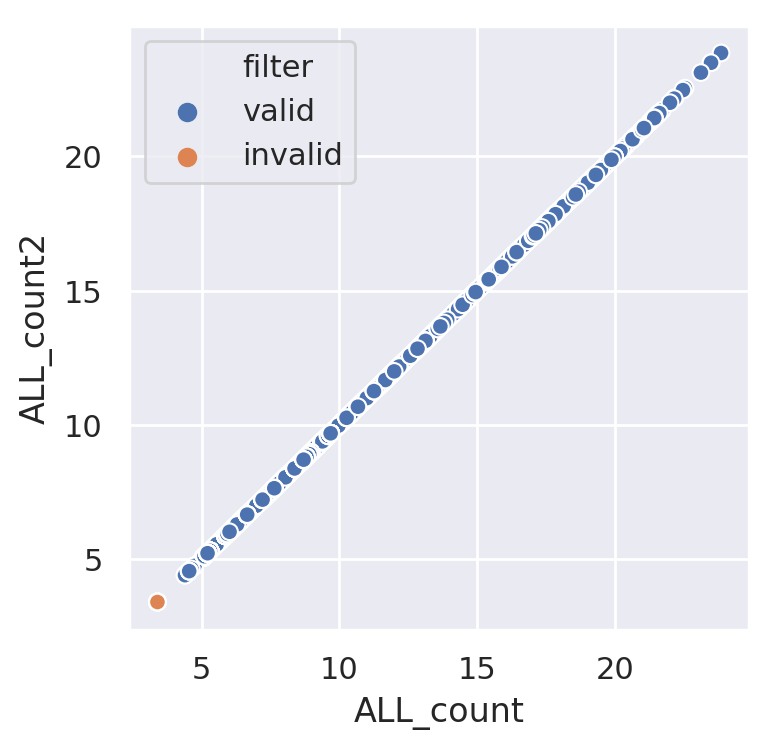

In [1246]:
fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=200)
sns.scatterplot(ax=ax, data=df, x='ALL_count', y='ALL_count2', hue='filter')#, style="time")
#sns.jointplot(data=df, x='ALL_count', y='ALL_count2', hue='filter')
plt.show()

## Transcript List

In [711]:
df_ref = pd.read_csv("/home/ryan/DRAP/data/c_elegans/transcript/mRNA_WS275_info.csv")
#df_ref = pd.read_excel("/home/ryan/DRAP/analyze/toolkit/drap/add_two_HCLee.RNAseq.master.xlsx")
df_ref = df_ref[['Gene ID','Gene name']]
df_ref['Gene ID'] = df_ref['Gene ID'].str.split('=', expand=True)[1]
df_ref.rename(columns={'Gene name':'Transcript Name'}, inplace=True)
df_ref

,Gene ID,Transcript Name
0,WBGene00007063,2L52.1a.1
1,WBGene00007063,2L52.1a.2
2,WBGene00007063,2L52.1b.1
3,WBGene00007064,2RSSE.1a.1
4,WBGene00007064,2RSSE.1b.1
5,WBGene00007064,2RSSE.1c.1
6,WBGene00007065,3R5.1a.1
7,WBGene00007065,3R5.1b.1
8,WBGene00003525,4R79.1a.1
9,WBGene00003525,4R79.1b.1


In [707]:
with open("/home/ryan/DRAP/analyze/toolkit/drap/gene_list/CSR-1_target", 'r') as f:
    file_name = "/home/ryan/DRAP/analyze/toolkit/drap/gene_list/CSR-1_target".split('/')[-1]
    lst = f.readlines()
    lst = [x[:-1] for x in lst]
    df2 = pd.DataFrame(lst, columns=[file_name])

df_ref[file_name] = df_ref["Transcript Name"].isin(df2['CSR-1_target'])
df_ref

,Gene ID,Transcript Name,CSR-1_target
0,WBGene00007063,2L52.1a.1,False
1,WBGene00007063,2L52.1a.2,False
2,WBGene00007063,2L52.1b.1,False
3,WBGene00007064,2RSSE.1a.1,False
4,WBGene00007064,2RSSE.1b.1,False
5,WBGene00007064,2RSSE.1c.1,False
6,WBGene00007065,3R5.1a.1,True
7,WBGene00007065,3R5.1b.1,True
8,WBGene00003525,4R79.1a.1,False
9,WBGene00003525,4R79.1b.1,False


In [678]:
import os
directory = "/home/ryan/DRAP/analyze/toolkit/drap/gene_list"
files = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        files.append(f)

In [724]:
for file in files:
    with open(file, 'r') as f:
        file_name = file.split('/')[-1]
        lst = f.readlines()
        lst = [x[:-1] for x in lst]
        df2 = pd.DataFrame(lst, columns=[file_name])
        df_ref[file_name] = df_ref["Transcript Name"].isin(df2[file_name])

lst = sorted(df_ref.columns)
lst.remove('Gene ID')
lst.remove('Transcript Name')
lst = ['Gene ID','Transcript Name'] + lst
df_ref = df_ref[lst]
df_ref.to_csv('/home/ryan/DRAP/data/c_elegans/transcript/mRNA_WS275_filter.csv', index=False)

In [737]:
df_ref = pd.read_csv('/home/ryan/DRAP/data/c_elegans/transcript/mRNA_WS275_filter.csv',
                     usecols=['Transcript Name','CSR-1_target', 'WAGO-1_target'#,'Gene ID'
                             ])
df_ref.rename(columns={'Transcript Name':'ref_id'}, inplace=True)
#df_ref = df_ref[df_ref['CSR-1_target']==True]
#del df_ref['CSR-1_target']
df_ref

,ref_id,CSR-1_target,WAGO-1_target
0,2L52.1a.1,False,True
1,2L52.1a.2,False,True
2,2L52.1b.1,False,True
3,2RSSE.1a.1,False,False
4,2RSSE.1b.1,False,False
5,2RSSE.1c.1,False,False
6,3R5.1a.1,True,False
7,3R5.1b.1,True,False
8,4R79.1a.1,False,False
9,4R79.1b.1,False,False


In [738]:
df_ref[ df_ref.values==True]

,ref_id,CSR-1_target,WAGO-1_target
0,2L52.1a.1,False,True
1,2L52.1a.2,False,True
2,2L52.1b.1,False,True
6,3R5.1a.1,True,False
7,3R5.1b.1,True,False
35,AC8.10.1,False,True
36,AC8.11.1,False,True
37,AC8.3.1,False,True
38,AC8.4.1,False,True
51,AH6.5.1,True,False


In [736]:
df_ref = df_ref.set_index("ref_id")
df_ref = df_ref[ df_ref.values==True]
df_ref

,CSR-1_target,WAGO-1_target
ref_id,,
2L52.1a.1,False,True
2L52.1a.2,False,True
2L52.1b.1,False,True
3R5.1a.1,True,False
3R5.1b.1,True,False
AC8.10.1,False,True
AC8.11.1,False,True
AC8.3.1,False,True
AC8.4.1,False,True


In [732]:
df_test = pd.merge(df_lst[0], df_ref, on='ref_id')
df_test = df_test.set_index('ref_id')
df_test

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ref_id,,,,,,,,,,,,,,,,,,,,,
3R5.1a.1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,1.484,2.969,2.969,2.969,2.969,2.969,2.969
3R5.1b.1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,1.484,2.969,2.969,2.969,2.969,2.969,2.969
AH6.5.1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,2.969,2.969,2.969,2.969,2.969,2.969,2.969,2.969,0.000,0.000
B0001.1a.1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
B0001.1a.2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
B0001.1b.1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
B0001.1c.1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
B0001.2.1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,2.969,2.969,2.969,2.969,2.969,2.969,2.969,0.000,0.000,0.000
B0001.3a.1,0.000,0.990,1.979,1.979,1.979,1.979,1.979,1.979,1.979,1.979,...,0.990,0.990,0.990,0.990,0.990,0.990,0.990,0.990,0.990,0.990
